In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
import pickle

import numpy as np
from lightgbm import LGBMRegressor

In [2]:
# topix銘柄を東証のファイルから取得
df_company = pd.read_excel('data/data_j.xls', sheet_name=0, index_col=0)
df_company = df_company.reset_index()
df_company = df_company.rename(columns={'コード':'code', '銘柄名':'name', '市場・商品区分':'market', '33業種区分':'cat33', '17業種区分':'cat17', '規模区分':'scale'})
df_company = df_company[['code','name', 'market', 'cat33', 'cat17', 'scale']]
df_company = df_company[df_company['scale'].str.contains('TOPIX')]
df_company = df_company[~df_company['scale'].str.contains('TOPIX Small ')]

In [12]:
df_company

,code,name,market,cat33,cat17,scale
19,1332,日本水産,プライム（内国株式）,水産・農林業,食品,TOPIX Mid400
20,1333,マルハニチロ,プライム（内国株式）,水産・農林業,食品,TOPIX Mid400
61,1414,ショーボンドホールディングス,プライム（内国株式）,建設業,建設・資材,TOPIX Mid400
62,1417,ミライト・ホールディングス,プライム（内国株式）,建設業,建設・資材,TOPIX Mid400
162,1605,ＩＮＰＥＸ,プライム（内国株式）,鉱業,エネルギー資源,TOPIX Mid400
...,...,...,...,...,...,...
4158,9962,ミスミグループ本社,プライム（内国株式）,卸売業,商社・卸売,TOPIX Mid400
4171,9983,ファーストリテイリング,プライム（内国株式）,小売業,小売,TOPIX Large70
4172,9984,ソフトバンクグループ,プライム（内国株式）,情報・通信業,情報通信・サービスその他,TOPIX Core30
4174,9987,スズケン,プライム（内国株式）,卸売業,商社・卸売,TOPIX Mid400


In [7]:
# get unique cat
codes = df_company.code.to_numpy()
cat33s = df_company.cat33.to_numpy()
cat17s = df_company.cat17.to_numpy()

# make dict
cat33_list = list(set(cat33s))
cat17_list = list(set(cat17s))
cat33_cat2num = {}
cat33_num2cat = {}
cat17_cat2num = {}
cat17_num2cat = {}
for i in range(len(cat33_list)):
    cat33_cat2num[cat33_list[i]] = i
    cat33_num2cat[i] = cat33_list[i]
for i in range(len(cat17_list)):
    cat17_cat2num[cat17_list[i]] = i
    cat17_num2cat[i] = cat17_list[i]

# convert code to cat
cat_dict = {}
for i in range(len(codes)):
    cat_dict[codes[i]] = [cat33_cat2num[cat33s[i]], cat17_cat2num[cat17s[i]]]


In [8]:
# get date
with open('data/closes_dict.pickle', 'rb') as f:
    closes_dict = pickle.load(f)

dates = []
for i in range(0, 23):
    for j in range(1, 12):
        date_20 = '20{:02}-{:02}-20'.format(i, j)
        dates.append(date_20)
    
closes_dict['date'] = dates

In [9]:
# get close df
df_closes = pd.DataFrame(closes_dict)

In [10]:
# macroの特徴量作成
df_macro = df_closes[df_closes.date <= '2022-06-20'][['date', '^N225', 'USDJPY=X', 'CL=F', '^TNX']]
for i in [3, 6, 12, 24, 36, 48]:
    df_macro['^N225_rel_{}'.format(i)] = df_macro['^N225'] / df_macro['^N225'].transform(lambda x: x.rolling(i, 1).mean())
    df_macro['USDJPY=X_rel_{}'.format(i)] = df_macro['USDJPY=X'] / df_macro['USDJPY=X'].transform(lambda x: x.rolling(i, 1).mean())
    df_macro['CL=F_rel_{}'.format(i)] = df_macro['CL=F'] / df_macro['CL=F'].transform(lambda x: x.rolling(i, 1).mean())
    df_macro['^TNX_rel_{}'.format(i)] = df_macro['^TNX'] / df_macro['^TNX'].transform(lambda x: x.rolling(i, 1).mean())

In [11]:
target_codes = [1332, 1333, 1414, 1417, 1605, 1721, 1801, 1802, 1803, 1808, 1812, 1820, 1860, 1878, 1893, 1911, 1925, 1928, 1944, 1951, 1959, 1963, 2002, 2127, 2175, 2181, 2201, 2206, 2212, 2229, 2264, 2267, 2269, 2270, 2282, 2331, 2371, 2412, 2413, 2427, 2432, 2433, 2492, 2501, 2502, 2503, 2531, 2579, 2587, 2593, 2607, 2651, 2670, 2768, 2784, 2801, 2802, 2809, 2810, 2811, 2815, 2871, 2875, 2897, 2914, 3003, 3038, 3064, 3086, 3088, 3092, 3099, 3101, 3105, 3107, 3116, 3141, 3197, 3231, 3288, 3289, 3291, 3349, 3360, 3382, 3391, 3401, 3402, 3405, 3407, 3436, 3549, 3563, 3591, 3626, 3635, 3659, 3697, 3765, 3769, 3774, 3861, 3863, 3880, 3923, 3941, 3994, 4004, 4005, 4021, 4042, 4043, 4045, 4061, 4062, 4063, 4088, 4091, 4114, 4118, 4151, 4182, 4183, 4185, 4186, 4188, 4202, 4203, 4204, 4205, 4206, 4208, 4272, 4307, 4324, 4401, 4403, 4443, 4452, 4502, 4503, 4506, 4507, 4516, 4519, 4521, 4523, 4527, 4528, 4530, 4534, 4536, 4540, 4543, 4544, 4552, 4568, 4578, 4581, 4587, 4612, 4613, 4631, 4661, 4665, 4666, 4676, 4681, 4684, 4686, 4689, 4704, 4716, 4732, 4739, 4751, 4755, 4768, 4887, 4901, 4902, 4911, 4912, 4919, 4921, 4922, 4927, 4967, 5019, 5020, 5021, 5076, 5101, 5105, 5108, 5110, 5201, 5214, 5232, 5233, 5301, 5332, 5333, 5334, 5401, 5406, 5411, 5444, 5463, 5471, 5486, 5631, 5703, 5706, 5711, 5713, 5714, 5801, 5802, 5901, 5929, 5938, 5947, 5991, 6005, 6028, 6098, 6103, 6113, 6134, 6136, 6141, 6146, 6178, 6201, 6268, 6273, 6301, 6302, 6305, 6326, 6361, 6367, 6370, 6383, 6395, 6406, 6417, 6436, 6448, 6457, 6460, 6465, 6471, 6472, 6473, 6479, 6481, 6501, 6502, 6503, 6504, 6506, 6532, 6586, 6592, 6594, 6645, 6674, 6701, 6702, 6723, 6724, 6728, 6752, 6753, 6754, 6755, 6758, 6762, 6770, 6806, 6841, 6845, 6849, 6856, 6857, 6861, 6869, 6902, 6920, 6923, 6925, 6951, 6952, 6954, 6963, 6965, 6967, 6971, 6976, 6981, 6988, 7011, 7012, 7013, 7164, 7167, 7180, 7181, 7182, 7186, 7201, 7202, 7203, 7205, 7211, 7240, 7259, 7261, 7267, 7269, 7270, 7272, 7276, 7282, 7309, 7313, 7337, 7453, 7458, 7459, 7476, 7518, 7532, 7550, 7616, 7649, 7701, 7730, 7731, 7732, 7733, 7735, 7741, 7747, 7751, 7752, 7780, 7832, 7846, 7911, 7912, 7936, 7947, 7951, 7956, 7966, 7974, 7984, 7988, 8001, 8002, 8012, 8015, 8031, 8035, 8053, 8056, 8058, 8060, 8086, 8088, 8111, 8113, 8129, 8136, 8227, 8233, 8252, 8253, 8267, 8273, 8279, 8282, 8283, 8303, 8304, 8306, 8308, 8309, 8316, 8331, 8334, 8354, 8355, 8359, 8369, 8377, 8382, 8385, 8410, 8411, 8418, 8439, 8473, 8570, 8572, 8591, 8593, 8595, 8601, 8604, 8630, 8697, 8725, 8750, 8766, 8795, 8801, 8802, 8804, 8830, 8876, 8905, 9001, 9003, 9005, 9006, 9007, 9008, 9009, 9020, 9021, 9022, 9024, 9031, 9041, 9042, 9044, 9045, 9048, 9064, 9065, 9072, 9076, 9086, 9101, 9104, 9107, 9142, 9143, 9147, 9201, 9202, 9301, 9364, 9401, 9404, 9409, 9432, 9433, 9434, 9435, 9449, 9468, 9501, 9502, 9503, 9504, 9505, 9506, 9507, 9508, 9509, 9513, 9531, 9532, 9533, 9601, 9602, 9613, 9627, 9684, 9697, 9706, 9719, 9735, 9744, 9766, 9783, 9831, 9832, 9843, 9861, 9962, 9983, 9984, 9987, 9989]

In [12]:
df_all = pd.DataFrame()
for code in target_codes:
    # 個別株のデータの取り出し
    df_i = df_closes[df_closes.date <= '2022-06-20'][['date', code, '^N225']]

    # カテゴリ
    df_i[['cat33', 'cat17']] = cat_dict[1332]

    # 株価の推移
    df_i['stock_pri'] = df_i[code]
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        df_i['stock_pri_{}'.format(i)] = df_i['stock_pri'].shift(i) / df_i['stock_pri']

    # 日経平均に対する値動き
    df_i['rel_pri'] = df_i['stock_pri'] / df_i['^N225']
    for i in range(0, 12):
        df_i['rel_ret_{}'.format(i)] = df_i['rel_pri'].shift(i) / df_i['rel_pri'].shift(i+1)
        df_i['rel_ret_{}'.format(i)] = df_i['rel_pri'].shift(i) / df_i['rel_pri'].shift(i+1)

    # センチメント
    for i in [3, 6, 12, 24, 36, 48]:
        df_i['stock_pri_rel_{}'.format(i)] = df_i['stock_pri'] / df_i['stock_pri'].transform(lambda x: x.rolling(i, 1).mean())
        df_i['rel_pri_rel_{}'.format(i)] = df_i['rel_pri'] / df_i['rel_pri'].transform(lambda x: x.rolling(i, 1).mean())


    df_i['target'] = np.log(df_i['rel_pri'].shift(-3)/df_i['rel_pri'])
    df_i = df_i.drop(code, axis=1)
    df_i = df_i.drop('^N225', axis=1)
    df_i['code_num'] = code

    df_i = pd.merge(df_i, df_macro, on='date')
    df_i = df_i[df_i.date >= '2005']

    df_all = pd.concat([df_all, df_i])

# 機械学習

In [13]:
# Numpy Version
def build_model():
    # Do feel free to experiment with different models here!
    model = LGBMRegressor(n_estimators = 1000, num_leaves = 500, max_depth = 10, learning_rate = 0.09)
    return model

In [14]:
features = ['cat33', 'cat17', 'stock_pri', 'stock_pri_1', 'stock_pri_2',
       'stock_pri_3', 'stock_pri_4', 'stock_pri_5', 'stock_pri_6',
       'stock_pri_7', 'stock_pri_8', 'stock_pri_9', 'stock_pri_10',
       'stock_pri_11', 'stock_pri_12', 'rel_pri', 'rel_ret_0', 'rel_ret_1',
       'rel_ret_2', 'rel_ret_3', 'rel_ret_4', 'rel_ret_5', 'rel_ret_6',
       'rel_ret_7', 'rel_ret_8', 'rel_ret_9', 'rel_ret_10', 'rel_ret_11',
       'stock_pri_rel_3', 'rel_pri_rel_3', 'stock_pri_rel_6', 'rel_pri_rel_6',
       'stock_pri_rel_12', 'rel_pri_rel_12', 'stock_pri_rel_24',
       'rel_pri_rel_24', 'stock_pri_rel_36', 'rel_pri_rel_36',
       'stock_pri_rel_48', 'rel_pri_rel_48', 'code_num', '^N225',
       'USDJPY=X', 'CL=F', '^TNX', '^N225_rel_3', 'USDJPY=X_rel_3',
       'CL=F_rel_3', '^TNX_rel_3', '^N225_rel_6', 'USDJPY=X_rel_6',
       'CL=F_rel_6', '^TNX_rel_6', '^N225_rel_12', 'USDJPY=X_rel_12',
       'CL=F_rel_12', '^TNX_rel_12', '^N225_rel_24', 'USDJPY=X_rel_24',
       'CL=F_rel_24', '^TNX_rel_24', '^N225_rel_36', 'USDJPY=X_rel_36',
       'CL=F_rel_36', '^TNX_rel_36', '^N225_rel_48', 'USDJPY=X_rel_48',
       'CL=F_rel_48', '^TNX_rel_48']

In [70]:
corrs = {}
for i in range(10, 23):
    start = '20{:02}'.format(i)
    end = '20{:02}'.format(i+1)
    df_train = df_all[df_all.date < start]
    df_val = df_all[(df_all.date >= start) & (df_all.date < end)]
    train_X, train_y = df_train[features], df_train['target'] 
    val_X, val_y = df_val[features], df_val['target'] 

    # make models
    model = build_model()
    model.fit( train_X, train_y)
    pred = model.predict(val_X)
    df_val['pred'] = pred

    df_pred = df_val[['pred', 'target']].dropna()
    corrs[start] = np.corrcoef(df_pred['pred'], df_pred['target'])[0][1]

/var/folders/jk/74x9q4ms33j_6fbn_1sfb7w40000gn/T/ipykernel_26297/3083820278.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['pred'] = pred


In [71]:
corrs

{'2010': 0.10664663573222209,
 '2011': 0.1444907134468864,
 '2012': -0.005677407005048693,
 '2013': 0.023443214181605658,
 '2014': 0.06491179000625585,
 '2015': -0.003551328765040099,
 '2016': 0.0475461592303449,
 '2017': 0.014572767750818939,
 '2018': 0.025769328581154605,
 '2019': 0.04385155907744095,
 '2020': 0.03822599087735819,
 '2021': 0.024387122988840274,
 '2022': 0.1440465453220842}

In [43]:
# make models
model = build_model()
model.fit( train_X, train_y)
pred = model.predict(val_X)
df_val['pred'] = pred

/var/folders/jk/74x9q4ms33j_6fbn_1sfb7w40000gn/T/ipykernel_26297/2153178893.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['pred'] = pred


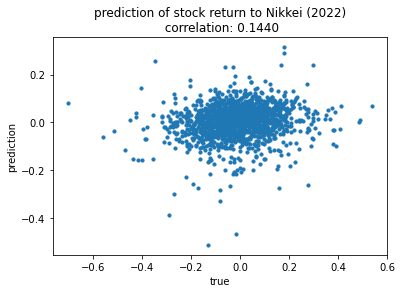

In [82]:
plt.scatter(df_val['target'],df_val['pred'],  s=10)
plt.ylabel('prediction')
plt.xlabel('true')
plt.title('prediction of stock return to Nikkei (2022)\n correlation: 0.1440')
plt.savefig('corr_2022.png')

# 銘柄選択

In [15]:
df_train = df_all[df_all.date < '2022-04-20']
df_val = df_all[df_all.date == '2022-06-20']
train_X, train_y = df_train[features], df_train['target'] 
val_X, val_y = df_val[features], df_val['target'] 

In [16]:
# make models
model = build_model()
model.fit( train_X, train_y)
pred = model.predict(val_X)
df_val['pred'] = pred

/var/folders/jk/74x9q4ms33j_6fbn_1sfb7w40000gn/T/ipykernel_51318/2153178893.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['pred'] = pred


In [17]:
df_result = pd.merge(df_val, df_company, left_on='code_num', right_on='code')

In [20]:
df_result.code_num

0      1332
1      1333
2      1414
3      1417
4      1605
       ... 
495    9962
496    9983
497    9984
498    9987
499    9989
Name: code_num, Length: 500, dtype: int64

In [ ]:
stds = []
for code_num in df_result.code_num.to_numpy():
    print(code_num)
    start = datetime.date(2021,6,27)
    end = datetime.date.today()
    closes = web.DataReader('{}.T'.format(code_num), 'yahoo', start, end).Close
    std = np.std(closes/closes.shift(1))
    stds.append(std)

In [35]:
df_result['std'] = stds

In [38]:
df_result['vol_for_1y'] = df_result['std'] * 16

In [39]:
df_result.to_csv('data/macro_ranking.csv')

In [33]:
df_closes[1332]

0      201.0
1      162.0
2      180.0
3      170.0
4      178.0
       ...  
248    568.0
249    568.0
250    568.0
251    568.0
252    568.0
Name: 1332, Length: 253, dtype: float64